In [5]:
!pip install ts2vg
!pip install igraph
!pip install pycairo
!pip install cairocffi
import pandas as pd
import numpy as np
import re

     |████████████████████████████████| 1.0 MB 14.3 MB/s 
     |████████████████████████████████| 3.2 MB 12.0 MB/s 
     |████████████████████████████████| 344 kB 12.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Failed building wheel for pycairo
Failed to build pycairo
ERROR: Could not build wheels for pycairo which use PEP 517 and cannot be installed directly
     |████████████████████████████████| 88 kB 5.0 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89667 sha256=37ca1dc27a4f03ba49db77d02ac6cd7a920898450b7474e9b6e0100431b44598
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [6]:
from google.colab import drive
drive.mount('/content/drive')

subject_list=['Subject1','Subject2','Subject3','Subject4','Subject5','Subject6','Subject7','Subject8','Subject9','Subject10','Subject11','Subject12','Subject13','Subject14','Subject15']
names_list = ['acc_climbingdown_chest.csv', 'acc_climbingup_chest.csv', 'acc_running_chest.csv', 'acc_walking_chest.csv']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
'''TASK 1'''
def Final_func():

  final_df = pd.DataFrame(columns = ['Method', 'Subject', 'Accelerometer Axis', 'Average Degree', 'Network Diameter', 'Average Path Length', 'Activity'])
  accelerometer_list = ['attr_x', 'attr_y', 'attr_z']

  for subject in subject_list:

    for names in names_list:
      names = '/content/drive/MyDrive/Colab Notebooks' + "/"  + subject + "/" + names

      for axes in accelerometer_list:
        
        #print(names)
        df=pd.read_csv(names)

        ts = df[axes][1000:2024]

        from ts2vg import NaturalVG
        g = NaturalVG()
        g.build(ts)
        ig_g = g.as_igraph()

        degree = np.mean(ig_g.degree())
        diameter = ig_g.diameter()
        average_path_length = ig_g.average_path_length()
        m = re.search('(?<=_).+(?=_)', names)
        m = m.group(0)

        df2 = {'Method': 'NVG', 'Subject' : subject, 'Accelerometer Axis' : axes, 'Average Degree' : degree, 'Network Diameter' : diameter, 'Average Path Length' : average_path_length, 'Activity' : m}
        final_df = final_df.append(df2, ignore_index = True)

        from ts2vg import HorizontalVG
        h = HorizontalVG()
        h.build(ts)
        ig_h = h.as_igraph()

        degree = np.mean(ig_h.degree())
        diameter = ig_h.diameter()
        average_path_length = ig_h.average_path_length()
        m = re.search('(?<=_).+(?=_)', names)
        m = m.group(0)

        df3 = {'Method': 'HVG', 'Subject' : subject, 'Accelerometer Axis' : axes, 'Average Degree' : degree, 'Network Diameter' : diameter, 'Average Path Length' : average_path_length, 'Activity' : m}
        final_df = final_df.append(df3, ignore_index = True)

  return final_df






In [8]:
final_df=Final_func()

In [9]:
final_df

,Method,Subject,Accelerometer Axis,Average Degree,Network Diameter,Average Path Length,Activity
0,NVG,Subject1,attr_x,15.609375,16,6.598815,climbingdown
1,HVG,Subject1,attr_x,3.951172,32,14.510884,climbingdown
2,NVG,Subject1,attr_y,14.087891,10,4.261784,climbingdown
3,HVG,Subject1,attr_y,3.947266,28,12.518642,climbingdown
4,NVG,Subject1,attr_z,9.562500,9,4.428011,climbingdown
...,...,...,...,...,...,...,...
355,HVG,Subject15,attr_x,3.935547,34,13.545222,walking
356,NVG,Subject15,attr_y,13.033203,12,4.654347,walking
357,HVG,Subject15,attr_y,3.958984,31,12.383202,walking
358,NVG,Subject15,attr_z,9.318359,12,4.945985,walking


In [10]:
plot_df_1=final_df[final_df['Activity'].isin(['running','walking'])]
plot_df_2=final_df[final_df['Activity'].isin(['climbingup','climbingdown'])]

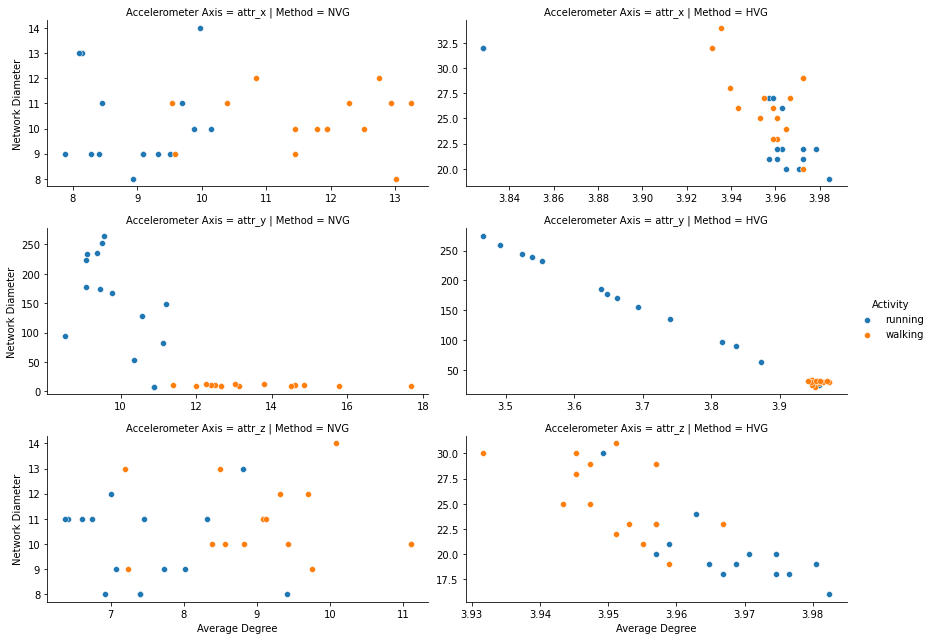

In [18]:
import  matplotlib.pyplot as plt
import seaborn as sns

g = sns.FacetGrid(plot_df_1,row="Accelerometer Axis", col="Method", hue="Activity", aspect= 2, sharey = False, sharex = False)
g.map(sns.scatterplot,"Average Degree","Network Diameter")
g.add_legend()

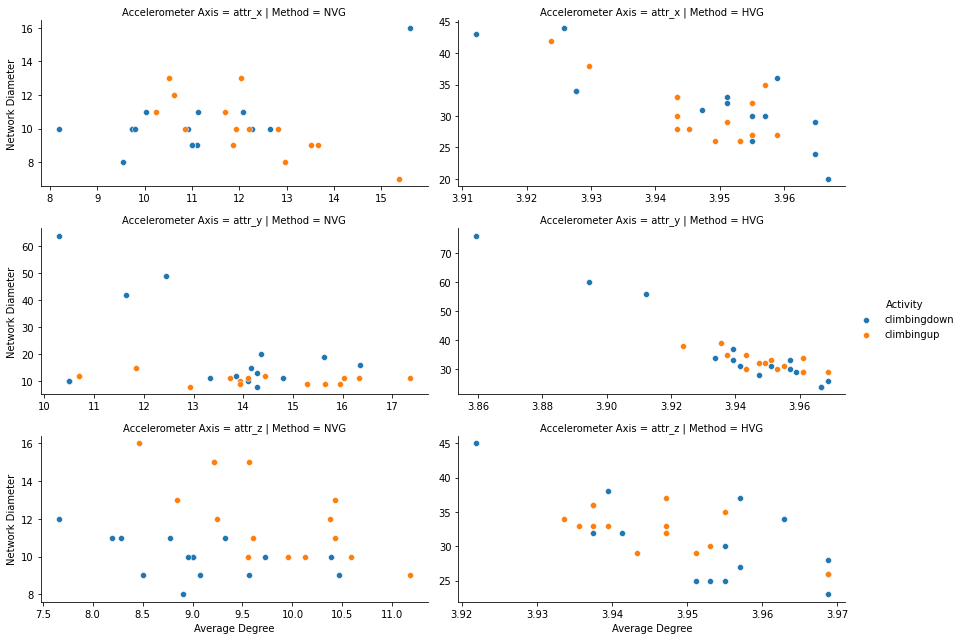

In [19]:
g = sns.FacetGrid(plot_df_2,row="Accelerometer Axis", col="Method", hue="Activity", aspect = 2, sharey = False, sharex = False)
g.map(sns.scatterplot,"Average Degree","Network Diameter")
g.add_legend()

In [13]:
'''TASK 2'''

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts) 

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*m-1):, :] 
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:]) 
    

def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

In [14]:
'''Question 1 & 2 '''
Signal = [1024, 2048, 4096]
Emdim = [3,4,5,6]
Emdelay = [1,2,3]
Attribute = ['attr_x','attr_y','attr_z']
lst=[]

for subject in subject_list:
  for names in names_list:
    names = '/content/drive/MyDrive/Colab Notebooks' + "/"  + subject + "/" + names
    for X in Signal:
      for Y in Emdim:
        for Z in Emdelay:
          for A in Attribute:
            op = pd.read_csv(names)
            op_walking = ordinal_patterns(op[A][1000:1000 + X],Y,Z)
            m = re.search('(?<=_).+(?=_)', names)
            m = m.group(0)
            data=[subject,A,X,Y,Z,p_entropy(op_walking),complexity(op_walking),m]
            lst.append(data)                

df=pd.DataFrame(lst,columns=['Subject','Accelerometer Axis','Signal','Dimension','Delay','Entropy','Complexity','Activity'])
df


,Subject,Accelerometer Axis,Signal,Dimension,Delay,Entropy,Complexity,Activity
0,Subject1,attr_x,1024,3,1,0.759158,0.181020,climbingdown
1,Subject1,attr_y,1024,3,1,0.783179,0.167354,climbingdown
2,Subject1,attr_z,1024,3,1,0.860857,0.116204,climbingdown
3,Subject1,attr_x,1024,3,2,0.897264,0.088867,climbingdown
4,Subject1,attr_y,1024,3,2,0.922633,0.068942,climbingdown
...,...,...,...,...,...,...,...,...
6475,Subject15,attr_y,4096,6,2,0.846715,0.233601,walking
6476,Subject15,attr_z,4096,6,2,0.873402,0.219104,walking
6477,Subject15,attr_x,4096,6,3,0.915252,0.168571,walking
6478,Subject15,attr_y,4096,6,3,0.858220,0.232702,walking


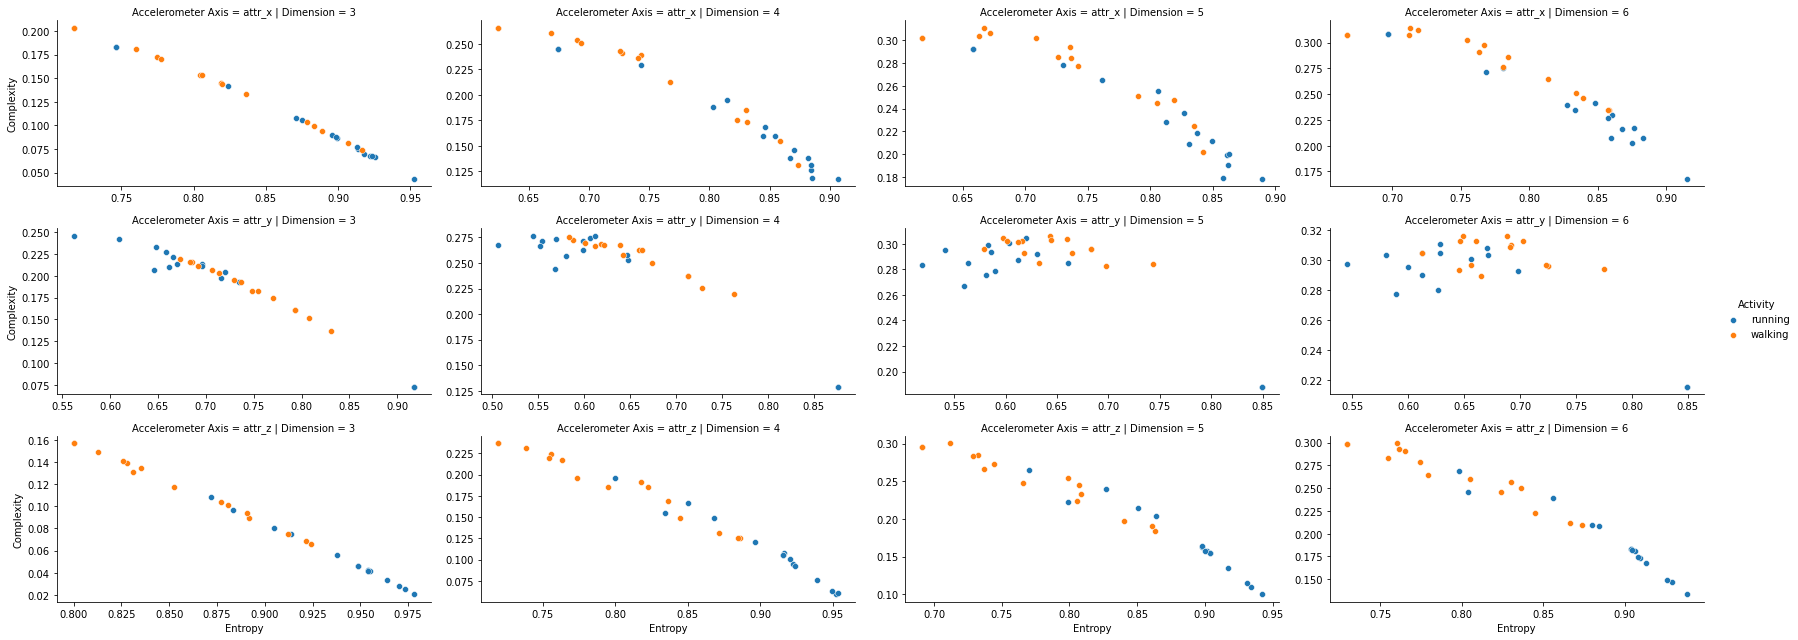

In [20]:
'''Question 3'''
import seaborn as sns
df_1 = df[(df["Signal"] == 4096) & (df["Delay"] ==1) & ((df["Activity"] == 'walking') | (df["Activity"] == 'running'))  ]
g = sns.FacetGrid(df_1,row="Accelerometer Axis",col = "Dimension", hue="Activity",aspect = 2, sharey = False, sharex = False)
g.map(sns.scatterplot,"Entropy","Complexity")
g.add_legend()

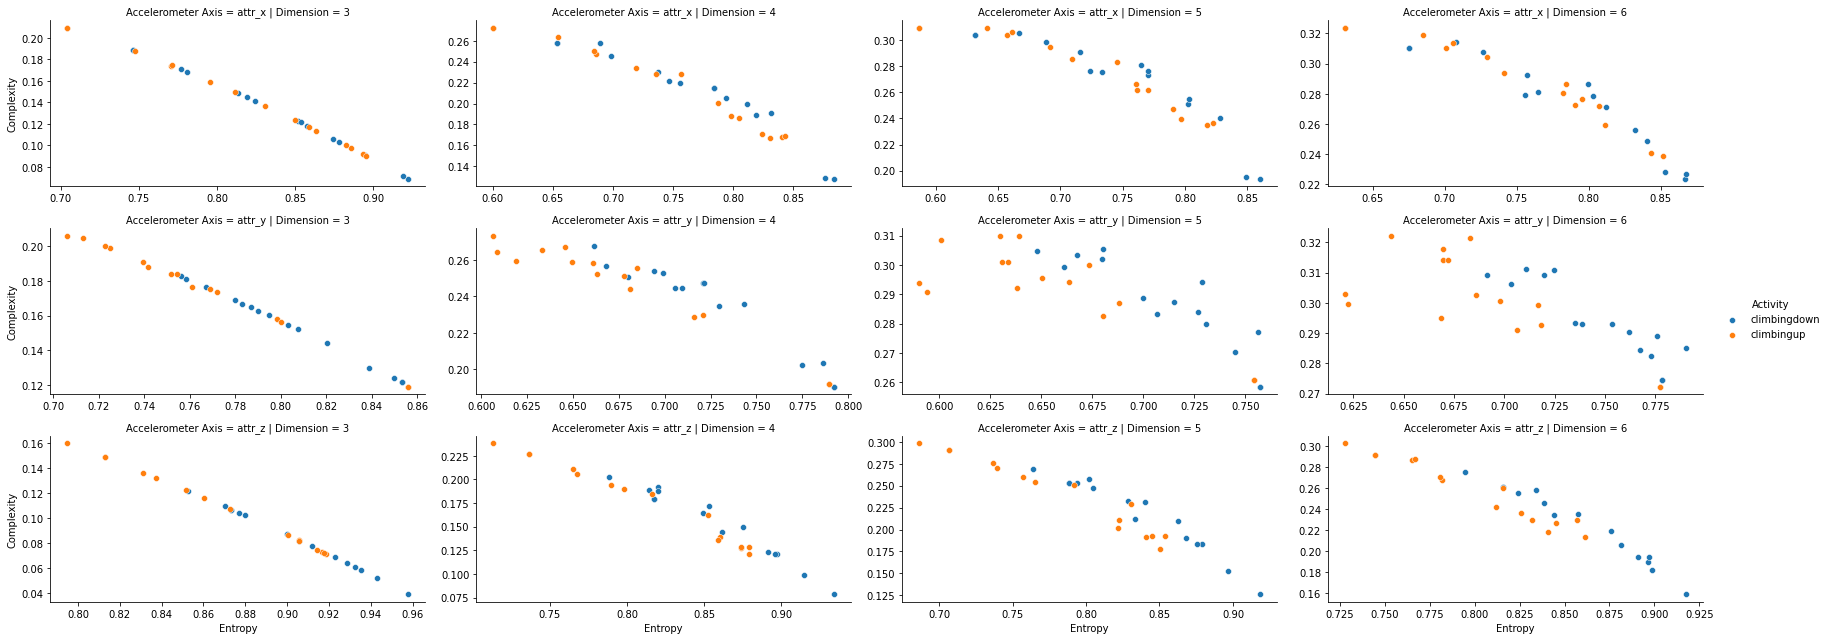

In [21]:
'''Question 4'''
df_2 = df[(df["Signal"] == 4096) & (df["Delay"] ==1) & ((df["Activity"] == 'climbingdown') | (df["Activity"] == 'climbingup'))  ]
g = sns.FacetGrid(df_2,row="Accelerometer Axis",col = "Dimension", hue="Activity",aspect = 2, sharey = False, sharex = False)
g.map(sns.scatterplot,"Entropy","Complexity")
g.add_legend()